In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "12345",
                            database = "ecommerce")

cur = db.cursor()

# 1.List all unique cities where customers are located.

In [48]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2.Count the number of orders placed in 2017.

In [49]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# 3.Find the total sales per category.

In [50]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4.Calculate the percentage of orders that were paid in installments.

In [51]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# 5.Count the number of customers from each state.

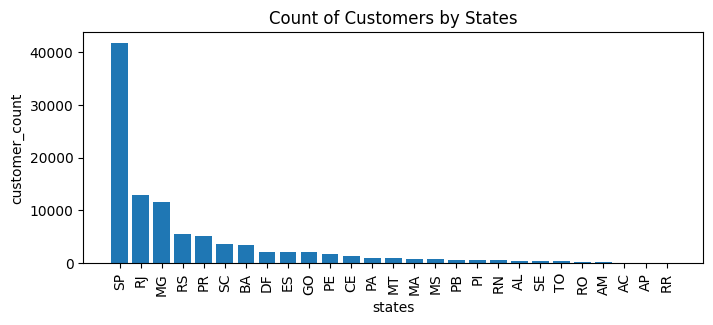

In [52]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# 6.Calculate the number of orders per month in 2018.

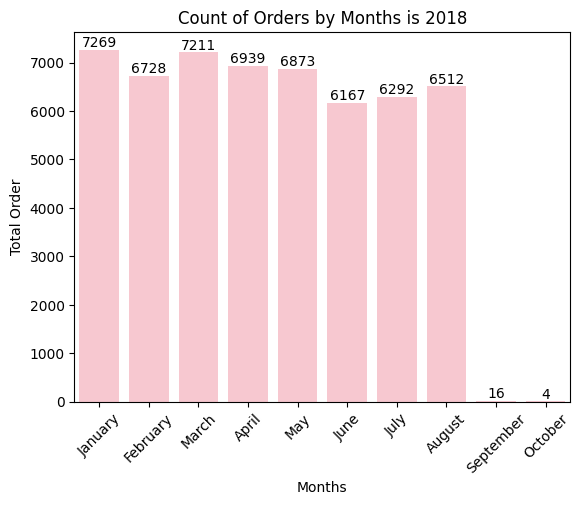

In [53]:
cmd = """SELECT monthname(order_purchase_timestamp) AS months, count(order_id) AS order_count 
FROM orders WHERE year(order_purchase_timestamp) = 2018 
GROUP BY month(order_purchase_timestamp), monthname(order_purchase_timestamp) ORDER BY month(order_purchase_timestamp)"""

cur.execute(cmd)
data = cur.fetchall()

columns = [des[0] for des in cur.description]
df = pd.DataFrame(data, columns=columns)

ax = sns.barplot(data=df, x="months", y="order_count", color="pink")
plt.xticks(rotation = 45)
plt.xlabel("Months")
plt.ylabel("Total Order")
plt.title("Count of Orders by Months is 2018")
ax.bar_label(ax.containers[0])
plt.show()

# 7.Find the average number of products per order, grouped by customer city.

In [54]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 8.Calculate the percentage of total revenue contributed by each product category.


In [55]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# 9.Identify the correlation between product price and the number of times a product has been purchased.

In [56]:
import numpy as np

query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# 10.Calculate the total revenue generated by each seller, and rank them by revenue.

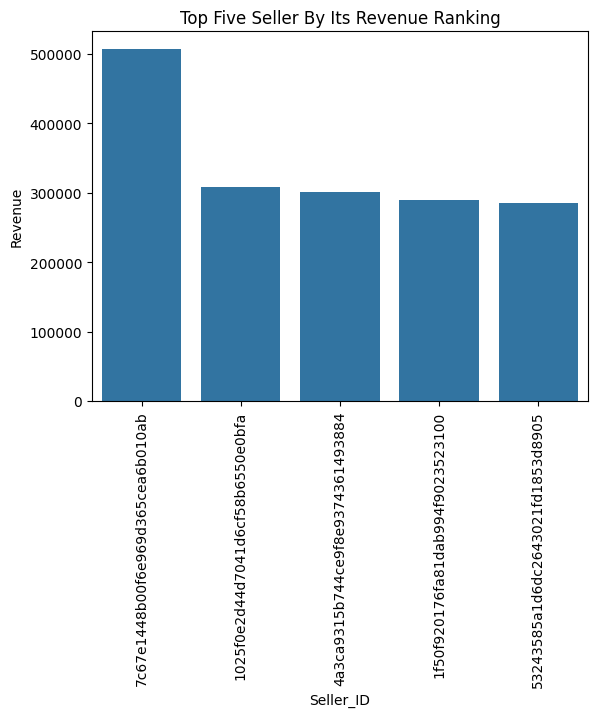

In [57]:
cur = db.cursor()
query = """select *,dense_rank() over(order by revenue desc) from (select order_items.seller_id as seller_id, sum(payments.payment_value) as revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Seller_ID", "Revenue","Rank"])
df = df.head()
sns.barplot(data=df, x="Seller_ID", y="Revenue")
plt.xticks(rotation=90)
plt.title("Top Five Seller By Its Revenue Ranking")
plt.show()

# 11.Calculate the moving average of order values for each customer over their order history.

In [58]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer_ID","Date_&_Time","Price","Average_Order_Value"])
df

,Customer_ID,Date_&_Time,Price,Average_Order_Value
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 12.Calculate the cumulative sales per month for each year.

    Years     Months       Sales  Cumulative_Sales
0    2018    January  1115004.18         8424113.0
1    2018   February   992463.34         9416577.0
2    2018      March  1159652.12        10576229.0
3    2018      April  1160785.48        11737014.0
4    2018        May  1153982.15        12890996.0
5    2018       June  1023880.50        13914877.0
6    2018       July  1066540.75        14981418.0
7    2018     August  1022425.32        16003843.0
8    2018  September     4439.54        16008282.0
9    2018    October      589.67        16008872.0
10   2017    January   138488.04          197850.0
11   2017   February   291908.01          489758.0
12   2017      March   449863.60          939622.0
13   2017      April   417788.03         1357410.0
14   2017        May   592918.82         1950329.0
15   2017       June   511276.38         2461605.0
16   2017       July   592382.92         3053988.0
17   2017     August   674396.32         3728384.0
18   2017  September   727762.4

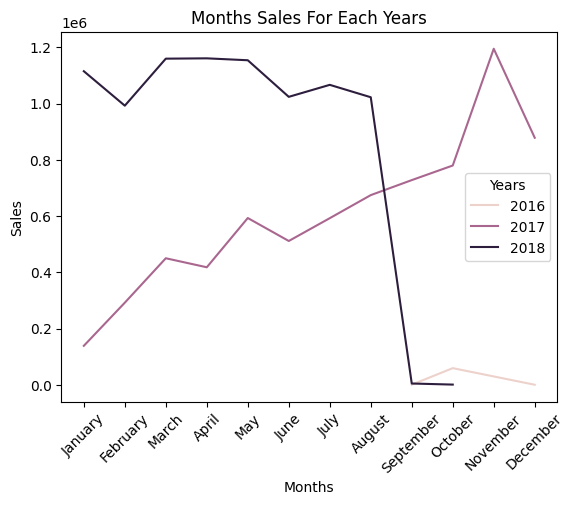

In [59]:
query = """select Years , Months , Sales, round(sum(Sales)
over(order by Years ,Month_Order)) as Cumulative_Sales from
(select year(order_purchase_timestamp) as Years, monthname(order_purchase_timestamp) as Months, month(order_purchase_timestamp) as Month_Order, round(sum(payments.payment_value),2) as Sales
from orders join payments
on orders.order_id = payments.order_id
group by Years , Months ,Month_Order) as a
order by Years desc,Month_Order ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years", "Months", "Sales", "Cumulative_Sales"])
print(df)
sns.lineplot(data=df, x="Months", y="Sales", hue="Years")
plt.xticks(rotation = 45)
plt.title("Months Sales For Each Years")
plt.show()

# 13.Calculate the year-over-year growth rate of total sales.

In [60]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 14.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [61]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

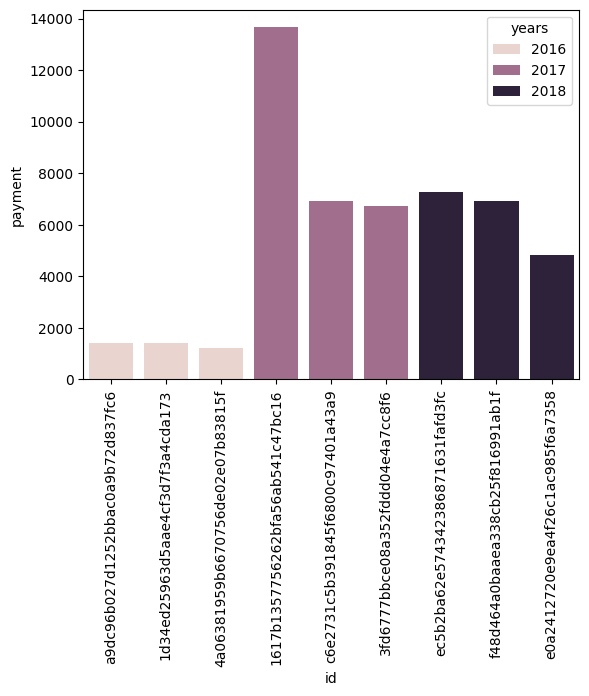

In [62]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()